In [1]:
import numpy as np

import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

import pandas as pd

In [43]:
df=pd.read_csv("../datas/BTC-USD.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-07-06,9072.849609,9375.474609,9058.664063,9375.474609,9375.474609,17889263252
1,2020-07-07,9349.161133,9360.617188,9201.815430,9252.277344,9252.277344,13839652595
2,2020-07-08,9253.020508,9450.335938,9249.500000,9428.333008,9428.333008,19702359883
3,2020-07-09,9427.994141,9431.378906,9234.999023,9277.967773,9277.967773,18000702524
4,2020-07-10,9273.357422,9287.471680,9118.001953,9278.807617,9278.807617,16860035605


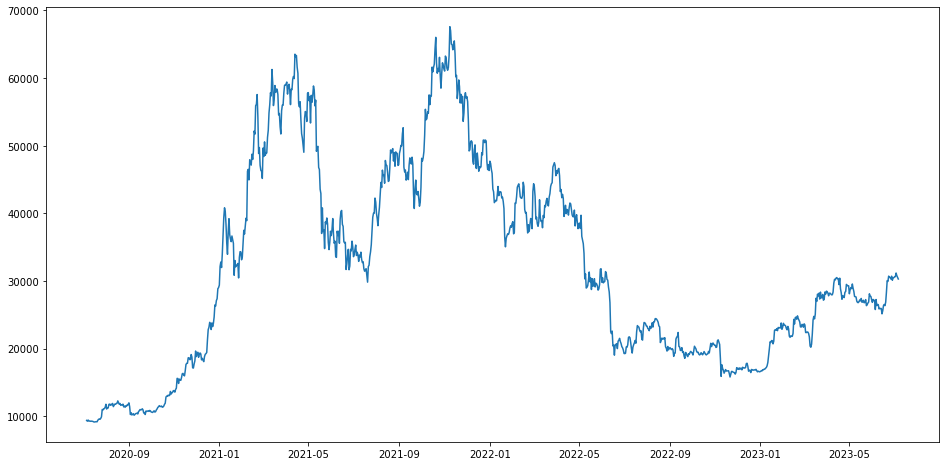

In [44]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [45]:
from keras.models import Sequential
from keras.layers import SimpleRNN,Embedding,GRU,Dense,Dropout,Activation

In [46]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

In [47]:
final_dataset=new_dataset.values

train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [48]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(units=50, activation='relu', input_shape=(10, scaled_data.shape[1]), return_sequences=True))
rnn_model.add(SimpleRNN(units=50, activation='relu'))
rnn_model.add(Dense(units=1))

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

rnn_model.compile(loss='mean_squared_error',optimizer='adam')
rnn_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

927/927 - 10s - loss: 0.0027


In [49]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=rnn_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

In [50]:
rnn_model.save("../models/rnn_model.h5")

<ipython-input-51-397e778e3e61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


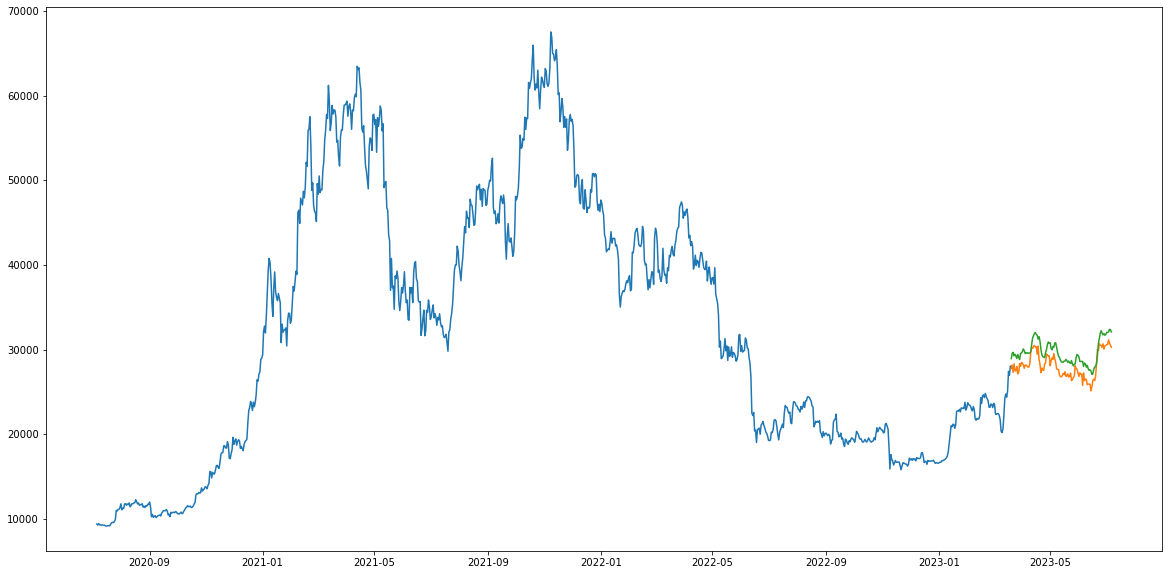

In [51]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])